<h1>CNN para Série Temporal</h1>

<h2>Introdução</h2>

<font size=4>Verificar a performance de redes neurais convolucionais para séries temporais, baseado no paper <a href=https://arxiv.org/pdf/1603.06995.pdf>Multi-Scale Convolutional Neural Networks for Time Series Classification</a> para entender o seu funcionamento para futuras aplicações.</font>

<h2>Índice</h2>

<font size=4>
    <ol>
        <li><a href=#CONF>Configurando as dependências</a></li>
        <li><a href=#BUILD>Construindo a CNN</a></li>
        <ol>
            <li><a href=#INPUT>Camada de Entrada e Convolução Local</a></li>
            <li><a href=#GLOBAL>Convolução Global</a></li>
        </ol>
        <li><a href=#SET>Formatando os dados</a></li>
        <li><a href=#TRAIN>Treinando o modelo</a></li>
        <li><a href=#VAL>Validando o modelo</a></li>
    </ol>
</font>

<a name=CONF></a>
<h2>Configurando as dependências</h2>

<font size=4>Importando as bibliotecas neceessárias</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Concatenate, Flatten, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

<font size=4>Carregando os dados e verificando as primeiras linhas</font>

In [2]:
data = pd.read_csv('./data/107_kw.csv', parse_dates=['date']).sort_values('date').set_index('date')
data.head()

,*kW_del
date,
2018-01-01 00:15:00,74803.2
2018-01-01 00:30:00,74918.4
2018-01-01 00:45:00,74918.4
2018-01-01 01:00:00,74841.6
2018-01-01 01:15:00,74227.2


<font size=4>Verificando a quantidade de nulos ou se houve um perído onde não foi coletado algum dado</font>

In [3]:
print('Quantidade de nulos: {}'.format(data.isnull().sum().values[0]))

Quantidade de nulos: 0


In [4]:
days_sample = pd.date_range(start='2018-01-01 00:15:00', end='2019-01-01', freq='15min').shape[0]
print('Quantidade de dias:\t{}\nQuantidade de amostras:\t{}'.format(days_sample, data.shape[0]))

Quantidade de dias:	35040
Quantidade de amostras:	35040


<font size=4>Vemos que não houve um período onde não foi coletado os dados</font>

<a name=BUILD></a>
<h2>Construindo a CNN</h2>

<font size=4>
A CNN tem 3 estágios: <i>transformação</i>, <i>convolução local</i> e <i>convolução global</i>. A tranformação será feita posteriormente com os dados, já que suas dimensões vão depender da camada de entrada da rede.<br>
Primeiro vamos começar com a camada de entrada e a etapa da convolução local.
</font>

<a name=INPUT></a>
<h3>Camada de Entrada e Convolução Local</h3>

<font size=4>
A CNN tem diversas entradas, que são: 
<ul>
    <li>Um pedaço da série temporal original:</li>
    <ul>
        <li>3 dias ou 288 linhas</li>
    </ul>
    <li>Multi-escala, que são subamostragens da série original:</li>
    <ul>
        <li>2 dias ou 192 linhas</li>
        <li>1 dia ou 96 linhas</li>
        <li>12 horas ou 48 linhas</li>
    </ul>
    <li>Multifrequência, que são médias móveis:</li>
    <ul>
        <li>Média móvel n=3</li>
        <li>Média móvel n=5</li>
        <li>Média móvel n=7</li>
    </ul>
</ul>
Como há entradas de diversas dimensões e após a convolução local as saídas são concatenadas, é necessário ajustar os hiperparâmetros da convolução e da maxpooling para que todos tenham a mesma dimensão, para isso há a seguinte forma para saber qual seria a saída.
<br><br>
\begin{align}
\mathbf{output\:shape} = \frac{input\:shape + kernel\:size + stride\:size}{pooling\:size} \\
\end{align}
</font>

<font size=4>Original</font>

In [5]:
# Original
inp_ori = Input(shape=(288, 1))
cnn_ori = Conv1D(filters=10, kernel_size=5, activation='relu')(inp_ori)
cnn_ori = MaxPooling1D(pool_size=12)(cnn_ori)

<font size=4>Multi-escala</font>

In [6]:
# Downsampling 12h
inp_ds12h = Input(shape=(48,1))
cnn_ds12 = Conv1D(filters=10, kernel_size=3, activation='relu')(inp_ds12h)
cnn_ds12 = MaxPooling1D(pool_size=2)(cnn_ds12)

# Downsampling 1d
inp_ds1d = Input(shape=(96,1))
cnn_ds1 = Conv1D(filters=10, kernel_size=5, activation='relu')(inp_ds1d)
cnn_ds1 = MaxPooling1D(pool_size=4)(cnn_ds1)

# Downsampling 2d
inp_ds2d = Input(shape=(192,1))
cnn_ds2 = Conv1D(filters=10, kernel_size=5, activation='relu')(inp_ds2d)
cnn_ds2 = MaxPooling1D(pool_size=8)(cnn_ds2)

<font size=4>Multifrequência</font>

In [7]:
# Média Móvel 3
inp_ra3 = Input(shape=(288,1))
cnn_ra3 = Conv1D(filters=10, kernel_size=5, activation='relu')(inp_ra3)
cnn_ra3 = MaxPooling1D(pool_size=12)(cnn_ra3)

# Média Móvel 5
inp_ra5 = Input(shape=(288,1))
cnn_ra5 = Conv1D(filters=10, kernel_size=5, activation='relu')(inp_ra5)
cnn_ra5 = MaxPooling1D(pool_size=12)(cnn_ra5)

# Média Móvel 7
inp_ra7 = Input(shape=(288,1))
cnn_ra7 = Conv1D(filters=10, kernel_size=5, activation='relu')(inp_ra7)
cnn_ra7 = MaxPooling1D(pool_size=12)(cnn_ra7)

<a name=GLOBAL></a>
<h3>Convolução Global</h3>

<font size=4>Nessa etapas é concatenado as saídas da etapa de convolução local e feito uma convolução com todas essas saídas, seguido de uma camada densa.</font>

In [8]:
cnn_full = Concatenate(axis=-1)([cnn_ori,
                                 cnn_ds12, cnn_ds1, cnn_ds2,
                                 cnn_ra3, cnn_ra5, cnn_ra7])
cnn_full = Conv1D(filters=10, kernel_size=3, activation='relu')(cnn_full)
cnn_full = MaxPooling1D(pool_size=3)(cnn_full)
cnn_full = Flatten()(cnn_full)
cnn_full = Dense(20, activation='relu')(cnn_full)
cnn_full = Dense(1)(cnn_full)
model = Model(inputs=[inp_ori,
                      inp_ds12h, inp_ds1d, inp_ds2d,
                      inp_ra3, inp_ra5, inp_ra7],
              outputs=cnn_full)
model.compile(optimizer='adam', loss='mse')

<font size=4>Printando as camadas da rede</font>

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 288, 1)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 48, 1)]      0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 96, 1)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 192, 1)]     0                                            
______________________________________________________________________________________________

<a name=SET></a>
<h2>Formatando os dados</h2>

<font size=4>Criando uma função para formatar as múltiplas entradas do rede neural</font>

In [10]:
def get_rows(dataframe):
    """Formata o dataset de acordo com cada entrada da rede neural e a variável target.
    """
    y = dataframe.iloc[-1:].values[0]
    # Original
    original = dataframe.iloc[-289:-1].values
    # Multi-escala
    dsamp_2d = dataframe.iloc[-193:-1].values
    dsamp_1d = dataframe.iloc[-97:-1].values
    dsamp_12h = dataframe.iloc[-49:-1].values
    #Multifrequência
    rolavg_7 = dataframe.rolling(window=7).sum().shift().iloc[-289:-1].values
    rolavg_5 = dataframe.rolling(window=5).sum().shift().iloc[-289:-1].values
    rolavg_3 = dataframe.rolling(window=3).sum().shift().iloc[-289:-1].values
    return original, dsamp_2d, dsamp_1d, dsamp_12h, rolavg_7, rolavg_5, rolavg_3, y

<font size=4>Formatando cada uma das entradas para alimentar o modelo</font>

In [11]:
original, dsamp_2d, dsamp_1d, dsamp_12h, rolavg_7, rolavg_5, rolavg_3, y = [], [], [], [], [], [], [], []
for i in range(385, data.shape[0]+1):
    ori, ds2d, ds1d, ds12h, ra7, ra5, ra3, yt = get_rows(data.iloc[i-385:i])
    # Original
    original.append(ori)
    # Multi-escala
    dsamp_2d.append(ds2d)
    dsamp_1d.append(ds1d)
    dsamp_12h.append(ds12h)
    # Multifrequência
    rolavg_7.append(ra7)
    rolavg_5.append(ra5)
    rolavg_3.append(ra3)
    y.append(yt)

y = np.array(y)
original = np.array(original)
dsamp_12h = np.array(dsamp_12h)
dsamp_1d = np.array(dsamp_1d)
dsamp_2d = np.array(dsamp_2d)
rolavg_3 = np.array(rolavg_3)
rolavg_5 = np.array(rolavg_5)
rolavg_7 = np.array(rolavg_7)

<font size=4>Dividindo em treino e teste</font>

In [12]:
idx = int(original.shape[0] * 0.4)
# Y
Y_train = y[:-idx]
Y_test = y[-idx:]
# Original
ori_train = original[:-idx,:,:]
ori_test = original[-idx:,:,:]
# Multi-escala
ds12h_train = dsamp_12h[:-idx,:,:]
ds12h_test = dsamp_12h[-idx:,:,:]
ds1d_train = dsamp_1d[:-idx,:,:]
ds1d_test = dsamp_1d[-idx:,:,:]
ds2d_train = dsamp_2d[:-idx,:,:]
ds2d_test = dsamp_2d[-idx:,:,:]
# Multifrequência
ra3_train = rolavg_3[:-idx,:,:]
ra3_test = rolavg_3[-idx:,:,:]
ra5_train = rolavg_5[:-idx,:,:]
ra5_test = rolavg_5[-idx:,:,:]
ra7_train = rolavg_7[:-idx,:,:]
ra7_test = rolavg_7[-idx:,:,:]

<a name=TRAIN></a>
<h2>Treinando o modelo</h2>

In [13]:
model.fit([ori_train, ds12h_train, ds1d_train, ds2d_train, ra3_train, ra5_train, ra7_train],
          Y_train, epochs=500, verbose=0)

<a name=VAL></a>
<h2>Validando o modelo</h2>

<font size=4>Prevendo no dataset de teste para validar o modelo com dados que não foram vistos, usando a MAE (Mean Average Error) e MSE (Mean Squared Error).</font>

In [14]:
y_pred = model.predict([ori_test, ds12h_test, ds1d_test, ds2d_test, ra3_test, ra5_test, ra7_test])
mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)

print(mae, mse)

421.85199184370947 295702.36224723764


<font size=4>Plotando as previsões do primeiro dia do dataset de teste</font>

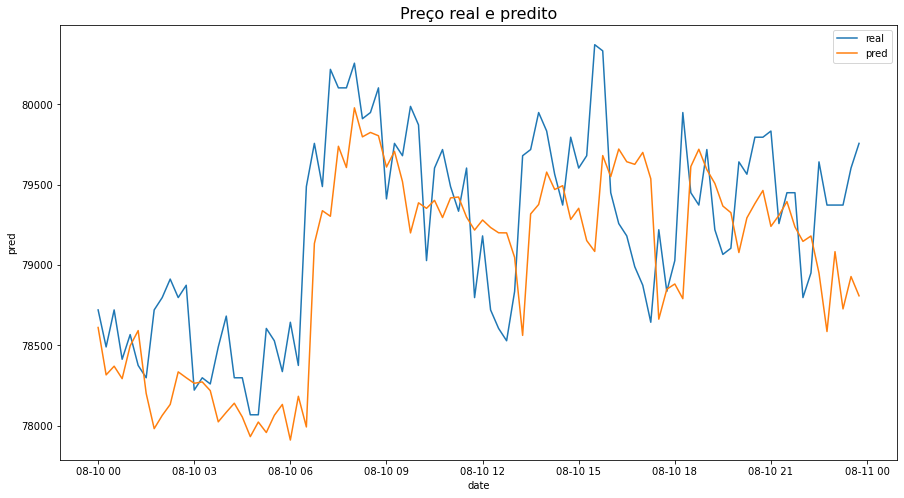

In [15]:
test = data.iloc[-idx:]
test.columns = ['ytrue']
test['pred'] = y_pred

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.lineplot(x=test.iloc[37:133].index, y=test.iloc[37:133]['ytrue'], label='real', ax=ax)
sns.lineplot(x=test.iloc[37:133].index, y=test.iloc[37:133]['pred'], label='pred', ax=ax)
ax.set_title('Preço real e predito', fontsize=16);

<font size=4>
Podemos ver que o modelo possui uma performance razoável, porém seria necessário testar mais opções para verificar o modelo mais a fundo, porém necessitaria de mais recursos computacionais para realizar isso.
<ul>
    <li>Aumentar a quantidade de dias no pedaço da série temporal original;</li>
    <li>Ao invés de down-sampling usar mais dias que a entrada original para captar tendências mais longas;</li>
    <li>Utilizar diferentes médias móvel, para verificar as médias móveis ótimas.</li>
</ul>
</font>